In [2]:
!nvidia-smi
%matplotlib inline

Tue Jun 24 18:19:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:CA:00.0 Off |                    0 |
| N/A   30C    P0             48W /  400W |       1MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [1]:
import dspy
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
from typing import List, Literal
from dspy.evaluate import Evaluate
from dspy import LabeledFewShot
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
import numpy as np

%matplotlib inline

In [2]:
def obtain_results_without(input_csv, filter_set):
    result_df = pd.read_csv(input_csv)
    result_df = result_df[result_df['direct_source']!=filter_set]
    print(classification_report(result_df["gold_judgment"], result_df['model_pred']))
    
    judgment_gold = result_df['gold_judgment'].tolist()
    judgment_model = result_df["model_pred"].tolist()
    binary_labels = ['underspecified', 'fully specified']

    cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

    disp.plot(cmap='Blues')  # 可以调整 colormap

In [4]:
# For Snellius
input_csv = "../data/few_shots.csv"
df_few_shots = pd.read_csv(input_csv)
real_csv = "../data/Test_1155.csv"
df_test_1155 = pd.read_csv(real_csv)
learning_csv = "../data/in-context_learning_set.csv"
df_in_context_learning = pd.read_csv(learning_csv)
learning_A_csv = "../data/learning_version_A.csv"
df_in_context_learning_A = pd.read_csv(learning_A_csv)
learning_B_csv = "../data/learning_version_B.csv"
df_in_context_learning_B = pd.read_csv(learning_B_csv)

In [ ]:
"""
module load CUDA/12.4.0
source ~/sglang-venv-2/bin/activate
huggingface-cli login


# 创建所有必要的目录
mkdir -p /scratch-local/yhuang/sglang_cache
mkdir -p /scratch-local/yhuang/huggingface_cache
mkdir -p /scratch-local/yhuang/torch_cache
mkdir -p /scratch-local/yhuang/cuda_cache
mkdir -p /scratch-local/yhuang/xdg_cache
mkdir -p /scratch-local/yhuang/tmp
mkdir -p /scratch-local/yhuang/logs

# 设置所有相关环境变量
export SGLANG_CACHE_DIR=/scratch-local/yhuang/sglang_cache
export TRANSFORMERS_CACHE=/scratch-local/yhuang/huggingface_cache
export HF_HOME=/scratch-local/yhuang/huggingface_cache
export HF_DATASETS_CACHE=/scratch-local/yhuang/huggingface_cache/datasets
export TORCH_HOME=/scratch-local/yhuang/torch_cache
export CUDA_CACHE_PATH=/scratch-local/yhuang/cuda_cache
export XDG_CACHE_HOME=/scratch-local/yhuang/xdg_cache
export TMPDIR=/scratch-local/yhuang/tmp
export TEMP=/scratch-local/yhuang/tmp
export TMP=/scratch-local/yhuang/tmp
export SGLANG_LOG_DIR=/scratch-local/yhuang/logs

# launching
python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-4B --trust-remote-code
CUDA_VISIBLE_DEVICES=0,1 python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-32B --trust-remote-code --tp 2
"""

In [5]:
model = dspy.LM("openai/Qwen/Qwen3-4B",
                 api_base="http://localhost:7501/v1",
                 api_key="whatever", model_type='chat', cache=False)

dspy.configure(lm=model)

In [6]:
def dspy_cot_no_theory(lm, input_list, class_to_use):

    judgment_list = []
    reasoning_list = []

    dspy.configure(lm=lm)
    classification = class_to_use

    for item in tqdm(input_list, desc="Processing: "):
        try:
          result = classification(query = item)
          judgment_list.append(result.judgment)
          reasoning_list.append(result.reasoning)
        except Exception as e:
          print(f'Error processing item: {item}')
          print(f'Error message: {e}')
          judgment_list.append("error")
          reasoning_list.append("error")

    return judgment_list, reasoning_list


def dspy_cot_theory(lm, input_list, class_to_use):
    category_list = []
    judgment_list = []
    reasoning_list = []

    dspy.configure(lm=lm)
    classification = class_to_use

    for item in tqdm(input_list, desc="Processing: "):
        try:
          result = classification(query = item)
          category_list.append(result.category)
          judgment_list.append(result.judgment)
          reasoning_list.append(result.reasoning)
        except Exception as e:
          print(f'Error processing item: {item}')
          print(f'Error message: {e}')
          category_list.append("error")
          judgment_list.append("error")
          reasoning_list.append("error")

    return category_list, judgment_list, reasoning_list


def collect_thinking(loaded_model):
  history_data = loaded_model.history
  think_list = []
  print(f'The current length of history is {len(history_data)}.')

  for record in history_data:
      thinking = record['outputs'][0].split("[[ ## binary_classification ## ]]")[0]
      think_list.append(thinking)

  return think_list

# Data loading and preprocessing
def load_data_no_theory(csv_path):
    """Load CSV data and convert to DSPy examples"""
    df = pd.read_csv(csv_path)

    examples = []
    for _, row in df.iterrows():
        if pd.notna(row['request']) and pd.notna(row['gold_judgment']):
            example = dspy.Example(
                query=row['request'],
                judgment=row['gold_judgment']
            ).with_inputs('request')  # Only request is input
            examples.append(example)

    return examples



def load_data_theory(csv_path):
    """Load CSV data and convert to DSPy examples"""
    df = pd.read_csv(csv_path)

    examples = []
    for _, row in df.iterrows():
        if pd.notna(row['request']) and pd.notna(row['gold_judgment']):
            example = dspy.Example(
                query=row['request'],
                reasoning=row['reasoning'] if pd.notna(row['reasoning']) else '',
                category=row['category'] if pd.notna(row['category']) else '',
                judgment=row['gold_judgment']
            ).with_inputs('request')  # Only request is input
            examples.append(example)

    return examples

# Evaluation metric
def judgment_accuracy(example, pred, trace=None):
    """Calculate accuracy of judgment prediction"""
    return example.judgment.lower().strip() == pred.judgment.lower().strip()

In [7]:
def run_experiment(test_df, model_in_use, program_in_use, think_file_name, input_col='request', theory=False):
  requests_to_test = test_df[input_col].tolist()

  if theory:
    category_list, judgment_list, reasoning_list = dspy_cot_theory(model_in_use, requests_to_test, program_in_use)
    df = test_df.copy()
    df['category'] = category_list
    df['model_pred'] = judgment_list
    df['reasoning'] = reasoning_list
    think_list = collect_thinking(model_in_use)
    print(f"The number of thinking pieces is {len(think_list)}.")
    think_df = pd.DataFrame(think_list)
    think_df.to_csv(f'{think_file_name}.csv')

  else:
    judgment_list, reasoning_list = dspy_cot_no_theory(model_in_use, requests_to_test, program_in_use)
    df = test_df.copy()
    df['model_pred'] = judgment_list
    df['reasoning'] = reasoning_list
    think_list = collect_thinking(model_in_use)
    print(f"The number of thinking pieces is {len(think_list)}.")
    think_df = pd.DataFrame(think_list)
    think_df.to_csv(f'{think_file_name}.csv')

  return df

def retrieve_results(result_df, output_name):
  judgment_list = result_df['model_pred'].tolist()

  if 'error' in judgment_list:
    print("There are errors in model predictions. The CSV file is saved but requires manual inspection.")
    result_df.to_csv(f'{output_name}_error.csv')
  else:
    print("No error is detected, proceed to evaluations.")
    print(classification_report(result_df['gold_judgment'], result_df['model_pred']))
    result_df.to_csv(f'{output_name}.csv')

  judgment_gold = result_df['gold_judgment'].tolist()
  judgment_model= result_df['model_pred'].tolist()

  binary_labels = ['underspecified', 'fully specified']

  cm = confusion_matrix(judgment_gold, judgment_model, labels=binary_labels)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=binary_labels)

  disp.plot(cmap='Blues')  # 可以调整 colormap

## Qwen3-4B DSPy CoT CONTROL W2

In [12]:
# Restart the model to clean the cache
model = dspy.LM("openai/Qwen/Qwen3-4B",
                 api_base="http://localhost:7501/v1",
                 api_key="whatever", model_type='chat', cache=False)

dspy.configure(lm=model)

In [13]:
# Load your in-context learning set
examples = load_data_no_theory(learning_csv)
print(f"Loaded {len(examples)} samples from in-context learning set")

optimizer = dspy.LabeledFewShot(k=150)

# Compiling
program = dspy.ChainOfThought(Classification_no_theory)
compiled_program = optimizer.compile(program, trainset=examples)


# One-shot Testing
result = compiled_program(query="Who is the president?")
print(result)

Loaded 150 samples from in-context learning set
Prediction(
    reasoning='The query "Who is the president?" is ambiguous as it does not specify which country or context is being referenced. The term "president" can apply to multiple countries and roles, requiring additional context to determine the correct answer.',
    judgment='underspecified'
)


In [ ]:
dspy.inspect_history()

In [14]:
experiment_result = run_experiment(df_test_1155, model, compiled_program, 'DSPy_FS_UND_ICL_think_contents')

Processing: 100%|██████████| 1155/1155 [1:32:10<00:00,  4.79s/it]

The current length of history is 1170.
The number of thinking pieces is 1170.


No error is detected, proceed to evaluations.
                 precision    recall  f1-score   support

fully specified       0.61      0.88      0.72       598
 underspecified       0.76      0.40      0.53       557

       accuracy                           0.65      1155
      macro avg       0.69      0.64      0.62      1155
   weighted avg       0.69      0.65      0.63      1155



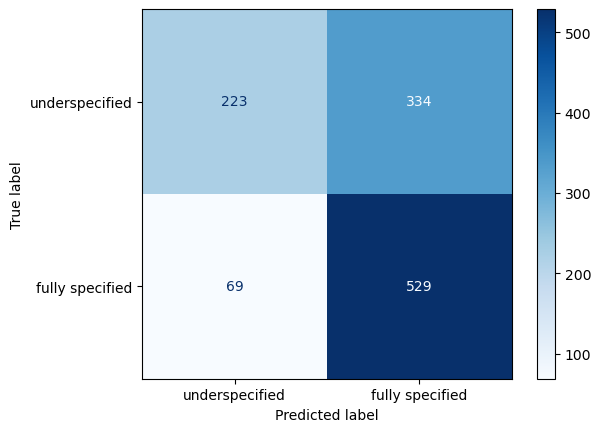

In [15]:
retrieve_results(experiment_result, 'DSPy_FS_UND_ICL')

                 precision    recall  f1-score   support

fully specified       0.63      0.87      0.73       431
 underspecified       0.79      0.49      0.60       424

       accuracy                           0.68       855
      macro avg       0.71      0.68      0.67       855
   weighted avg       0.71      0.68      0.67       855



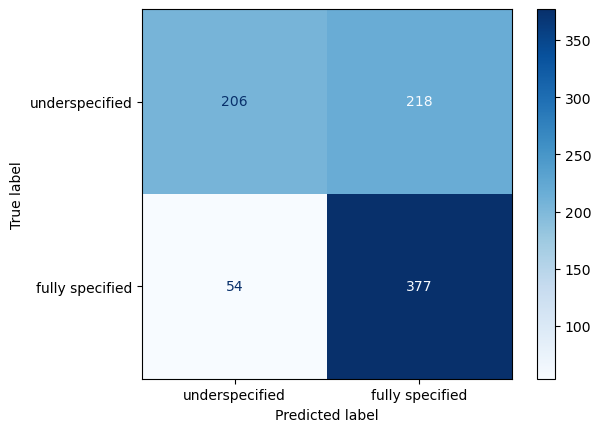

In [5]:
obtain_results_without('DSPy_FS_UND_ICL.csv', 'AmbigQA')

## Qwen3 4B DSPy CoT MINI W2

In [16]:
# Restart the model to clean the cache
model = dspy.LM("openai/Qwen/Qwen3-4B",
                 api_base="http://localhost:7501/v1",
                 api_key="whatever", model_type='chat', cache=False)

dspy.configure(lm=model)

In [19]:
category_desc = "Select one or more labels (comma-separated) from 'Undetermined perspective or granularity', 'Missing necessary components', 'Undetermined lexicons or references', 'Undetermined standard or preference' if any undetermined factors exist. If the query is completely clear, output 'fully specified'."
judgment_desc = "'underspecified' if any undetermined factors exist in the query, 'fully specified' if the query is completely clear."

class Classification_theory(dspy.Signature):
  query: str = dspy.InputField(desc="An input user query.")
  category: Literal['Undetermined perspective or granularity', 'Missing necessary components', 'Undetermined lexicons or references', 'Undetermined standard or preference', 'fully specified']=dspy.OutputField(desc=category_desc)
  judgment: Literal['underspecified', 'fully specified'] = dspy.OutputField(desc=judgment_desc)

program = dspy.ChainOfThought(Classification_theory)

# One-shot Testing
result = program(query="Who is the president?")
print(result)

Prediction(
    reasoning='The query "Who is the president?" lacks context about which country or organization is being referenced. The term "president" can apply to multiple countries or entities, and the query does not specify a particular jurisdiction or context.',
    category='Missing necessary components',
    judgment='underspecified'
)


In [20]:
dspy.inspect_history()





[2025-06-24T19:58:03.041826]

System message:

Your input fields are:
1. `query` (str): An input user query.

Your output fields are:
1. `reasoning` (str)
2. `category` (Literal['Undetermined perspective or granularity', 'Missing necessary components', 'Undetermined lexicons or references', 'Undetermined standard or preference', 'fully specified']): Select one or more labels (comma-separated) from 'Undetermined perspective or granularity', 'Missing necessary components', 'Undetermined lexicons or references', 'Undetermined standard or preference' if any undetermined factors exist. If the query is completely clear, output 'fully specified'.
3. `judgment` (Literal['underspecified', 'fully specified']): 'underspecified' if any undetermined factors exist in the query, 'fully specified' if the query is completely clear.

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## query ## ]]
{query}

[[ ## reasoning ## ]]
{reasoning}

[[ ## ca

In [21]:
experiment_result = run_experiment(df_test_1155, model, program, 'DSPy_FS_UND_categories_think_contents')

Processing: 100%|██████████| 1155/1155 [1:35:52<00:00,  4.98s/it]

The current length of history is 1376.
The number of thinking pieces is 1376.


No error is detected, proceed to evaluations.
                 precision    recall  f1-score   support

fully specified       0.64      0.75      0.69       598
 underspecified       0.67      0.55      0.60       557

       accuracy                           0.65      1155
      macro avg       0.66      0.65      0.65      1155
   weighted avg       0.66      0.65      0.65      1155



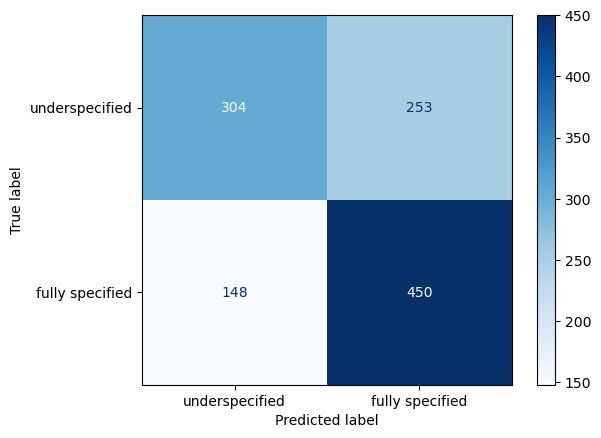

In [22]:
retrieve_results(experiment_result, 'DSPy_FS_UND_categories')

                 precision    recall  f1-score   support

fully specified       0.68      0.74      0.71       431
 underspecified       0.71      0.64      0.67       424

       accuracy                           0.69       855
      macro avg       0.69      0.69      0.69       855
   weighted avg       0.69      0.69      0.69       855



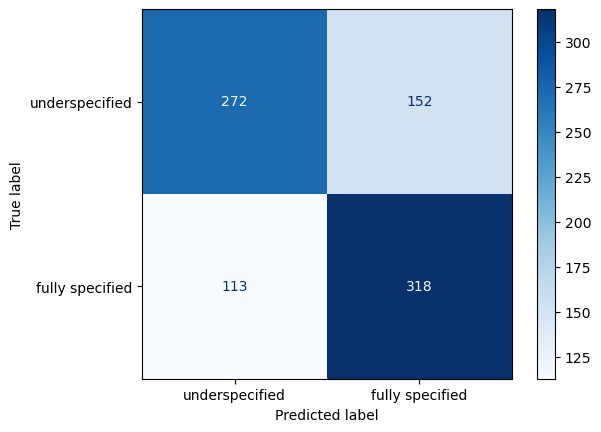

In [4]:
obtain_results_without('DSPy_FS_UND_categories.csv', 'AmbigQA')

## Qwen3 4B DSPy CoT LIGHT W2

In [24]:
# Restart the model to clean the cache
model = dspy.LM("openai/Qwen/Qwen3-4B",
                 api_base="http://localhost:7501/v1",
                 api_key="whatever", model_type='chat', cache=False)

dspy.configure(lm=model)

In [25]:
# Load your in-context learning set
examples = load_data_theory(learning_csv)
print(f"Loaded {len(examples)} samples from in-context learning set")

optimizer = dspy.LabeledFewShot(k=150)

# Compiling
program = dspy.ChainOfThought(Classification_theory)
compiled_program = optimizer.compile(program, trainset=examples)


# One-shot Testing
result = compiled_program(query="Who is the president?")
print(result)

Loaded 150 samples from in-context learning set
Prediction(
    reasoning='The request is underspecified because the term "president" can refer to multiple parallel political entities (e.g., the President of the United States, the President of France, or the President of China), and the question lacks a necessary component to specify which country or context is intended. Without this, the referent remains ambiguous.',
    category='Undetermined lexicons or references',
    judgment='underspecified'
)


In [ ]:
dspy.inspect_history()

In [27]:
experiment_result = run_experiment(df_test_1155, model, compiled_program, 'DSPy_FS_UND_fulltheory_think_contents')

Processing: 100%|██████████| 1155/1155 [2:02:32<00:00,  6.37s/it] 

The current length of history is 1368.
The number of thinking pieces is 1368.


No error is detected, proceed to evaluations.
                 precision    recall  f1-score   support

fully specified       0.67      0.72      0.69       598
 underspecified       0.67      0.62      0.64       557

       accuracy                           0.67      1155
      macro avg       0.67      0.67      0.67      1155
   weighted avg       0.67      0.67      0.67      1155



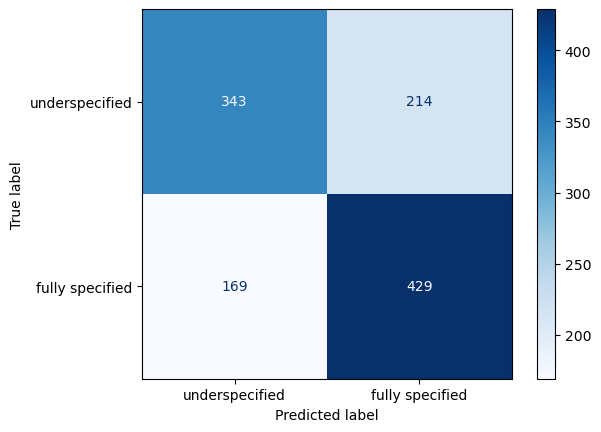

In [28]:
retrieve_results(experiment_result, 'DSPy_FS_UND_fulltheory')

                 precision    recall  f1-score   support

fully specified       0.72      0.68      0.70       431
 underspecified       0.69      0.74      0.71       424

       accuracy                           0.71       855
      macro avg       0.71      0.71      0.71       855
   weighted avg       0.71      0.71      0.71       855



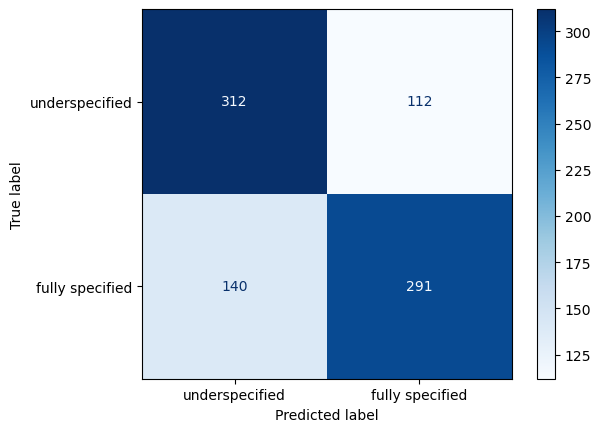

In [3]:
obtain_results_without('DSPy_FS_UND_fulltheory.csv', 'AmbigQA')